# Script to show how to convert and import the data into UW

A coordinate system that uses a unit length measurement is required. 

This script uses the CRUST1.0 dataset to convert the data into a usable format in Underworld.

The different coordinate systems that can be used can be found [here](https://epsg.io/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import netcdf
import rasterio
import os
from scipy.interpolate import RegularGridInterpolator

%matplotlib inline

In [2]:
"""Need to make this a function built into the Underwater package"""

from Convert_data import transform_coordinates



# Elevation map of Australia example

## Importing the topogrphy into Underworld

Importing all the functions required for the model

In [3]:
import underworld as uw

import numpy as np
import pandas as pd
import os
import csv


from scipy.interpolate import RegularGridInterpolator, LinearNDInterpolator
from scipy.spatial import cKDTree
from scipy import optimize

import underworld.visualisation as vis
import matplotlib.pyplot as plt


import argparse
from time import time

from mpi4py import MPI
comm = MPI.COMM_WORLD

### additional requirements, may need to be installed
import xarray as xr
import rioxarray




%matplotlib inline

### Setting up the model dimensions

In [4]:
# define bounding box
xmin, xmax, ymin, ymax = 1.45e7, 1.55e7, -3e6, -2e6
zmin, zmax = -2000.0, 2000.0

# resolution
dx, dy, dz = 5e3, 5e3, 1e3
Nx, Ny, Nz = int((xmax-xmin)/dx), int((ymax-ymin)/dy), int((zmax-zmin)/dz)

if uw.mpi.rank == 0:
    print("global number of elements in x,y,z {} | total number of elements = {}".format((Nx,Ny,Nz), Nx*Ny*Nz))

global number of elements in x,y,z (200, 200, 4) | total number of elements = 160000


### Creating the mesh

In [5]:
deformedmesh = True
elementType = "Q1"
mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = (Nx,Ny,Nz), 
                                 minCoord    = (xmin,ymin,zmin), 
                                 maxCoord    = (xmax,ymax,zmax)) 

gwHydraulicHead            = mesh.add_variable( nodeDofCount=1 )
temperatureField           = mesh.add_variable( nodeDofCount=1 )
temperatureField0          = mesh.add_variable( nodeDofCount=1 )
velocityField              = mesh.add_variable( nodeDofCount=3 )
heatProductionField        = mesh.add_variable( nodeDofCount=1 )



coords = mesh.data

Xcoords = np.unique(coords[:,0])
Ycoords = np.unique(coords[:,1])
Zcoords = np.unique(coords[:,2])
nx, ny, nz = Xcoords.size, Ycoords.size, Zcoords.size

### Deforming the top surface to the topography
Uses uw.mpi.rank to reduce memory when run in parallel

Topography data available from [here](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/79616)

In [6]:
AusElevation_interp = None
if uw.mpi.rank == 0:
    
    ### import dataset
    with rioxarray.open_rasterio('Example_data/79616_Global_Map_Images/'+'elevation.tif') as data:
        x = data.sel(band=1).x.data
        y = data.sel(band=1).y.data
        z = data.sel(band=1).data
    
    ### create grid of data to be flattened
    xv, yv = np.meshgrid(x,y)
        
    # ### Convert dataset
    x_new, y_new = transform_coordinates(xv.flatten(), yv.flatten(), 4326, 3857)
    
    ### create surface interploation function to deform the top of the mesh
    AusElevation_interp = RegularGridInterpolator((np.unique(y_new), np.unique(x_new)), np.flipud(z), bounds_error=False)


    
        
    
        
uw.mpi.comm.barrier()

AusElevation_interp = uw.mpi.comm.bcast(AusElevation_interp, root=0)

uw.mpi.comm.barrier()

    
local_topography = AusElevation_interp((mesh.data[:,1], mesh.data[:,0]))

# depth above which to deform
z_deform = zmin

with mesh.deform_mesh():
    zcube = coords[:,2].reshape(nz,ny,nx)
    zcube_norm = zcube.copy()
    zcube_norm -= z_deform
    zcube_norm /= zmax - z_deform
    zcube_mask = zcube_norm < 0
    
    # difference to add to existing z coordinates
    dzcube = zcube_norm * -(zmax - local_topography.reshape(zcube.shape))
    
    mesh.data[:,2] += dzcube.ravel()
    coords = mesh.data

In [7]:
### Used to extract the x y z values of the top wall
topWall = mesh.specialSets["MaxK_VertexSet"]

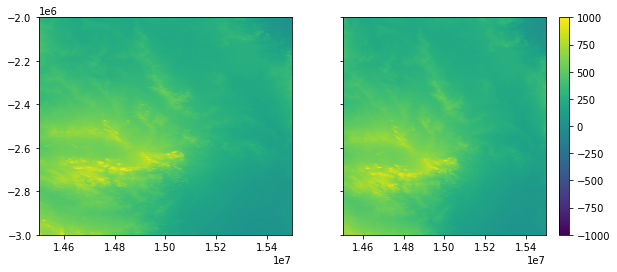

In [8]:
### Plot data to see if it looks the same as the original data
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,4))
### plot oroginal data but limit x and y axis
ax1.scatter(x_new[::50], y_new[::50], c=z.flatten()[::50], vmin=-1000, vmax=1000)
ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)
### Plot the top surface of the model
sc = ax2.scatter(mesh.data[:,0][topWall], mesh.data[:,1][topWall], c=mesh.data[:,2][topWall], vmin=-1000, vmax=1000)

plt.colorbar(sc)

### some details/features missing due to the large dy and dx values which results in smoothing of the topography